In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud
import contractions
# Text Processing
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine Learning packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Model training and evaluation
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_twitter = pd.read_csv('./dataset/twitter_MBTI.csv', index_col=False)
df_twitter.drop(df_twitter.columns[0], axis=1, inplace=True)
df_twitter.rename(columns={"text": "posts",
                    "label": "type"}, inplace=True)
# df_mbti_2 = pd.read_csv('./dataset/mbti_full_pull.csv', index_col=False,encoding='ISO-8859-1')
df_mbti_1 = pd.read_csv('./dataset/mbti_1.csv', index_col=False)
df_mbti_2 = pd.read_csv('./dataset/mbti_full_pull.20240326001448439backup.csv', index_col=False,encoding='ISO-8859-1')
df_mbti_2.rename(columns={"label": "type","body": "posts" }, inplace=True)
df_mbti_2.drop(df_mbti_2.columns[0], axis=1, inplace=True)
MBTI_DS = pd.concat([df_mbti_1,df_twitter
                     # ,df_mbti_2
                    ])
MBTI_DS['type']=MBTI_DS['type'].str.upper()
# MBTI_DS = pd.read_csv("/dataset/mbti_1.csv")
MBTI_DS.tail()
MBTI_DS

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
7806,INTP,"@sobsjjun God,,pls take care 😕|||@sobsjjun Hir..."
7807,INTP,@Ignis_02 wow last time i got intp https://t.c...
7808,ENTP,@akupilled A 100%|||@akupilled That SOMEONE wi...
7809,INFJ,If you’re #INTJ this one is for you | What is ...


In [3]:
MBTI_DS.isnull().any()

type     False
posts    False
dtype: bool

In [4]:
nRow, nCol = MBTI_DS.shape
print(f'There are {nRow} rows and {nCol} columns')


There are 16486 rows and 2 columns


In [5]:
MBTI_DS.dtypes


type     object
posts    object
dtype: object

In [6]:
MBTI_DS.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16486 entries, 0 to 7810
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    16486 non-null  object
 1   posts   16486 non-null  object
dtypes: object(2)
memory usage: 386.4+ KB


## **SUMMARY**

#### - JUST 2 columns in MBTI DATASET
#### - Number rows IS 8675
#### - No null valuesin MBTI DATASET
#### - -All values are textual, So we should convert to numeric form to train the Machine Learning model

In [7]:
MBTI_DS.describe(include=['object'])

,type,posts
count,16486,16486
unique,16,16256
top,INFP,"@AzurLane_EN No Shinano rerun yet, huh?|||@ASM..."
freq,3114,2


**We see**
There are 16 unique personality type indicators in the dataset
**INFP** most frequently occuring personality type

Number of occurences is 1832

In [8]:
types = np.unique(np.array(MBTI_DS['type']))
print("The Unique values 'type' of personality column",types)

The Unique values 'type' of personality column ['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']


In [9]:
total = MBTI_DS.groupby(['type']).count()
print("The Total Posts for every Personality Type")
total

The Total Posts for every Personality Type


,posts
type,
ENFJ,708
ENFP,1404
ENTJ,510
ENTP,1262
ESFJ,147
ESFP,222
ESTJ,120
ESTP,189
INFJ,2527


**Data visualization**

Text(0.5, 1.0, 'Total post each personality type')

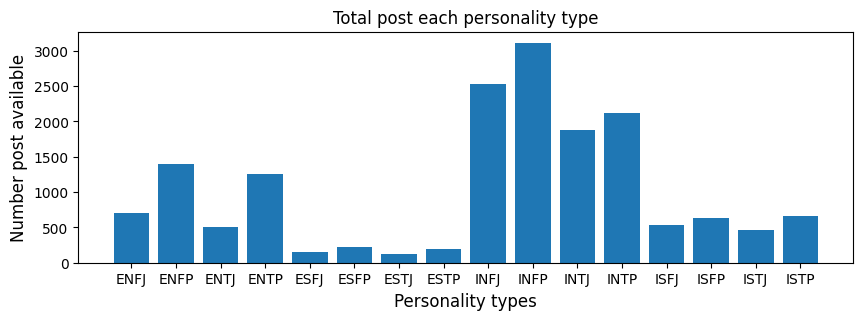

In [10]:
plt.figure(figsize = (10,3))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 12)
plt.ylabel('Number post available', size = 12)
plt.title('Total post each personality type')

The MBTI DATASET is unbalanced throughout the different classes. Some personality types has more data than others, The **INFP (Introvert Intuition Feeling Perceiving)** the highest

Since the original dataset only came with 2 features, the Type and 50 posts for each person, we decided to create additional features for exploring & analysing our dataset.

After we added our features, we did some data exploration to see how the raw data looks and to see how important our features were for distinguishing types across the MBTI personalities. Below are plots further showing the type imbalances in our data.


<Axes: xlabel='type', ylabel='word_each_comment'>

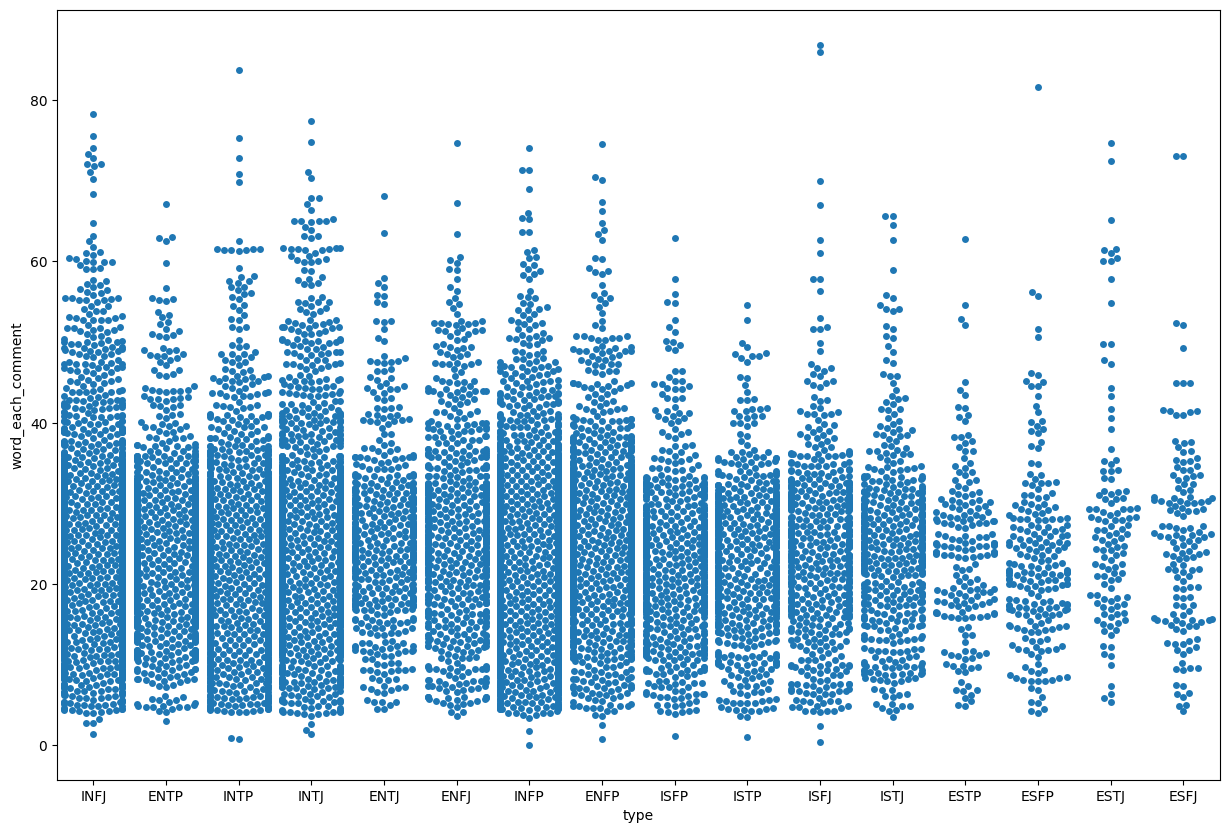

In [11]:
# MBTI_DS_C = MBTI_DS.copy()
#Count Number words for each post of a user
def var_row(row):
    l = []
    for i in str(row).split('|||'):
        l.append(len(i.split()))
    return np.var(l)

#Count Number words per post for total 50 posts in whole row
MBTI_DS['word_each_comment'] = MBTI_DS['posts'].apply(lambda x: len(str(x).split())/50)
MBTI_DS['variance_word_count'] = MBTI_DS['posts'].apply(lambda x: var_row(x))

plt.figure(figsize=(15,10))
sns.swarmplot(x="type", y="word_each_comment", data=MBTI_DS)

**INFP** has the most cluttered showing there are most number of comments of this type of personality

**DISTANCE PLOT** This seaborn visualization method shows the histogram distribution data for single column.

Text(0.5, 1.0, 'Distribution of Lengths of all 50 Posts')

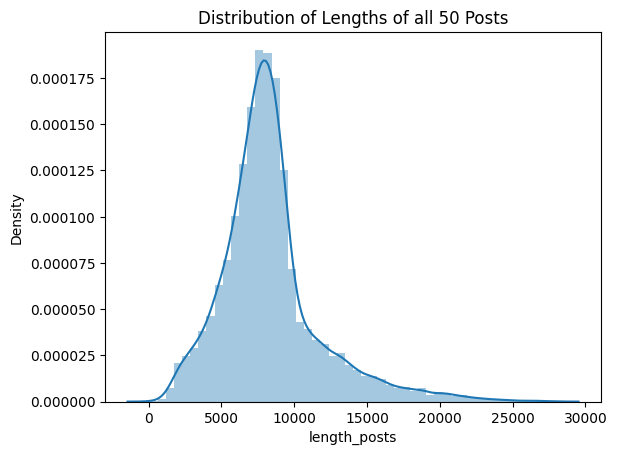

In [12]:
MBTI_DS["length_posts"] = MBTI_DS["posts"].apply(len)
sns.distplot(MBTI_DS["length_posts"]).set_title("Distribution of Lengths of all 50 Posts")

We can see that most no of lengthly posts have between **7000-9000 words**.

In [13]:
#Finding the most common words in all posts.
words = list(MBTI_DS["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(50)

[('I', 558699),
 ('the', 479232),
 ('to', 474178),
 ('a', 389172),
 ('and', 361098),
 ('of', 277247),
 ('is', 243461),
 ('you', 219527),
 ('my', 204475),
 ('in', 199230),
 ('that', 192297),
 ('it', 162500),
 ('for', 161826),
 ('i', 145716),
 ('but', 127850),
 ('have', 127071),
 ('with', 118993),
 ('so', 118973),
 ('this', 118405),
 ('me', 116148),
 ('be', 115971),
 ('like', 112819),
 ('on', 109901),
 ('are', 106979),
 ('was', 98869),
 ('not', 96783),
 ('just', 90650),
 ('an', 78907),
 ('as', 76626),
 ("I'm", 72703),
 ('about', 70877),
 ('do', 68123),
 ('at', 67412),
 ('your', 65755),
 ('or', 64817),
 ('think', 64795),
 ('if', 62442),
 ('what', 60895),
 ('can', 60727),
 ("don't", 56485),
 ('when', 56141),
 ('all', 55697),
 ('they', 54640),
 ('people', 52185),
 ('get', 51486),
 ('one', 50168),
 ('know', 50104),
 ('would', 48134),
 ('am', 47388),
 ('from', 46992)]

The posts contain general words like : I, to, the, a, and, of, is, you etc. 

we assume that these words don't really provide any useful information to train the Machine Learning model as most of them are stop-words or other useless words.


**WORDCLOUD**

In [14]:

# wc = wordcloud.WordCloud(width=1000, height=100, collocations=False, background_color="white", colormap="tab20b").generate(" ".join(words))

# # collocations to False  is set to ensure that the word cloud doesn't appear as if it contains any duplicate words
# plt.figure(figsize=(25,10))
# # generate word cloud, interpolation 
# plt.imshow(wc, interpolation='bilinear')
# _ = plt.axis("off")

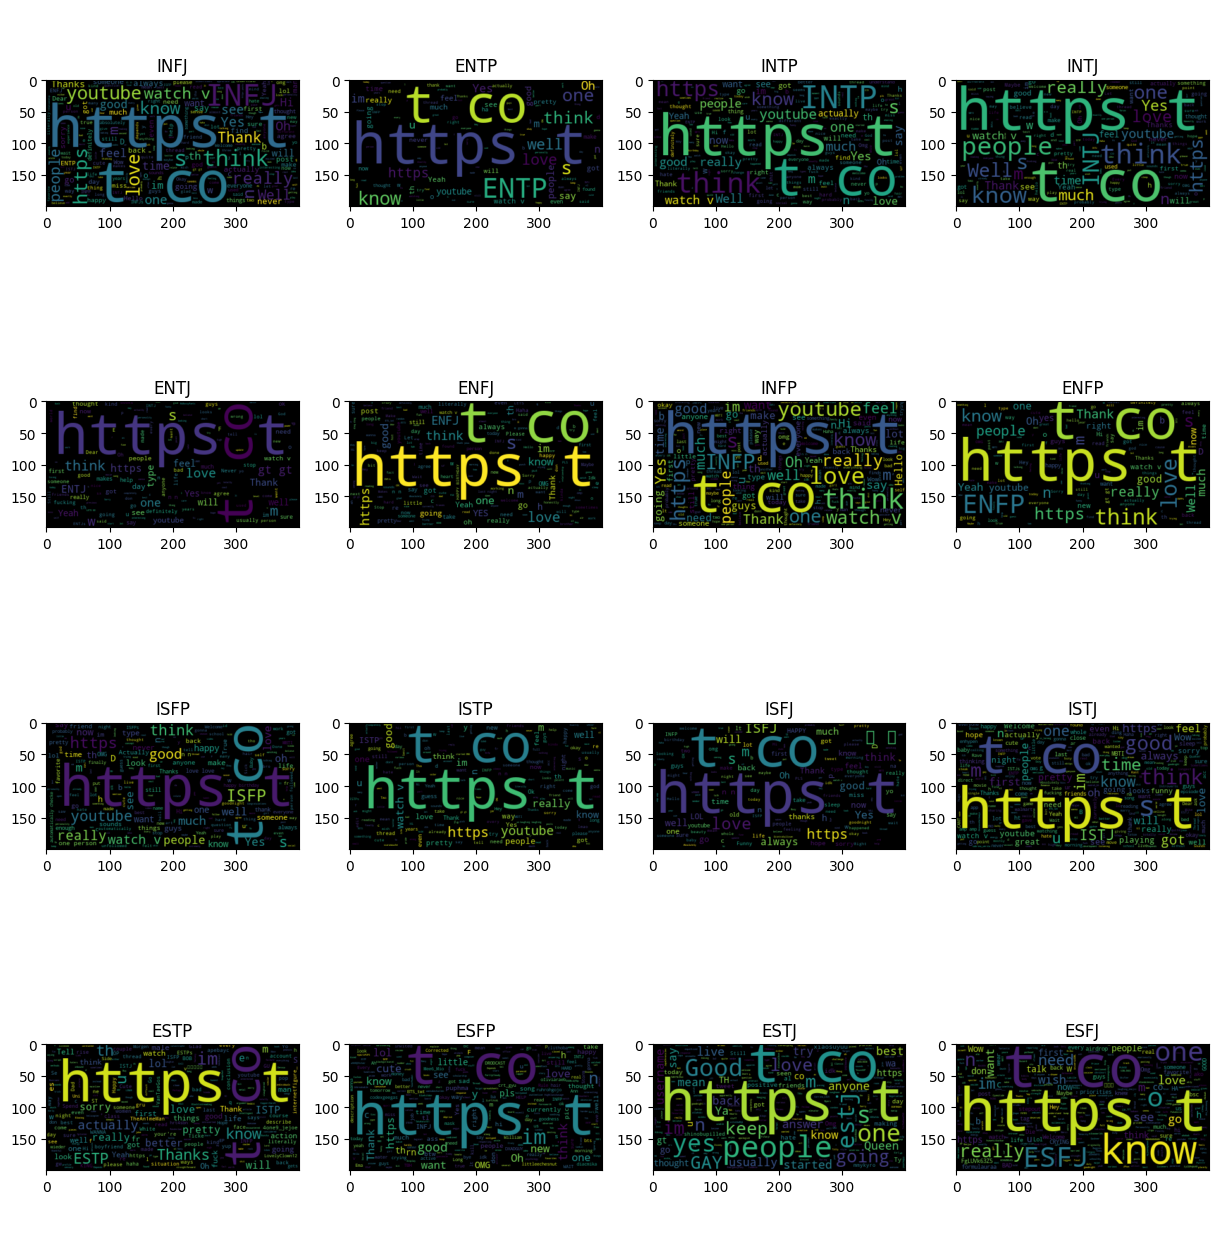

In [15]:
fig, ax = plt.subplots(len(MBTI_DS['type'].unique()), figsize=(15,len(MBTI_DS['type'].unique())))
k = 0
for i in MBTI_DS['type'].unique():
    df_4 = MBTI_DS[MBTI_DS['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

we can see there are a number of irrelevant words present in the dataset **(e.g. ha, ar, Ti etx.)** which will need to be removed Interestingly, among the most common words in the word clouds of individual personality types, is the **names of MBTI personlity types themselves**.
It would hence be necessary to clean our posts by removing these MBTI words from each of them as part of our pre-processing stage, before training the model for better evaluation results.


In [16]:
#add columns for personality type indicators

def get_types(row):
    t=row['type']
    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found') 
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

MBTI_DS_N = pd.concat([MBTI_DS,MBTI_DS.apply(lambda row: get_types(row),axis=1)],axis=1)
MBTI_DS_N

,type,posts,word_each_comment,variance_word_count,length_posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.290000,4652,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.475600,7053,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.690000,5265,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.832400,6271,1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.457600,6111,0,1,1,1
...,...,...,...,...,...,...,...,...,...
7806,INTP,"@sobsjjun God,,pls take care 😕|||@sobsjjun Hir...",15.96,15.306467,6545,1,1,1,0
7807,INTP,@Ignis_02 wow last time i got intp https://t.c...,21.96,32.449600,10235,1,1,1,0
7808,ENTP,@akupilled A 100%|||@akupilled That SOMEONE wi...,22.86,28.547975,8416,0,1,1,0
7809,INFJ,If you’re #INTJ this one is for you | What is ...,33.36,50.830316,13800,1,1,0,1


The above code assigns a value of 1 to individuals who possess the traits of Introversion (I), Intuition (N), Thinking (T), and Judging (J) on the four axes of the Myers-Briggs Type Indicator (MBTI) - Introversion-Extraversion (IE), Intuition-Sensing (NS), Feeling-Thinking (FT), and Judging-Perceiving (JP). All other individuals are assigned a value of 0.

This allows us to calculate the number of posts that correspond to introverted individuals versus extroverted individuals out of all the entries in the labeled Kaggle dataset. This analysis is conducted to examine the dataset for each individual personality index of the MBTI.


In [17]:
#Counting Number posts in one class | Total Number posts in other class

print ("Introversion (I) |  Extroversion (E): \t", MBTI_DS_N['IE'].value_counts()[0], " | ", MBTI_DS_N['IE'].value_counts()[1])
print ("Intuition    (N) |  Sensing      (S): \t", MBTI_DS_N['NS'].value_counts()[0], " | ", MBTI_DS_N['NS'].value_counts()[1])
print ("Thinking     (T) |  Feeling      (F): \t", MBTI_DS_N['TF'].value_counts()[0], " | ", MBTI_DS_N['TF'].value_counts()[1])
print ("Judging      (J) |  Perceiving   (P): \t", MBTI_DS_N['JP'].value_counts()[0], " | ", MBTI_DS_N['JP'].value_counts()[1])


Introversion (I) |  Extroversion (E): 	 4562  |  11924
Intuition    (N) |  Sensing      (S): 	 2974  |  13512
Thinking     (T) |  Feeling      (F): 	 9290  |  7196
Judging      (J) |  Perceiving   (P): 	 9608  |  6878


We can see that there is an uneven distribution of the entries in our dataset across the four axes of the MBTI, with E being the majority in the IE axis, S being the majority in the NS axis, and relatively less difference between T and F in the TF axis, and J and P in the JP axis.


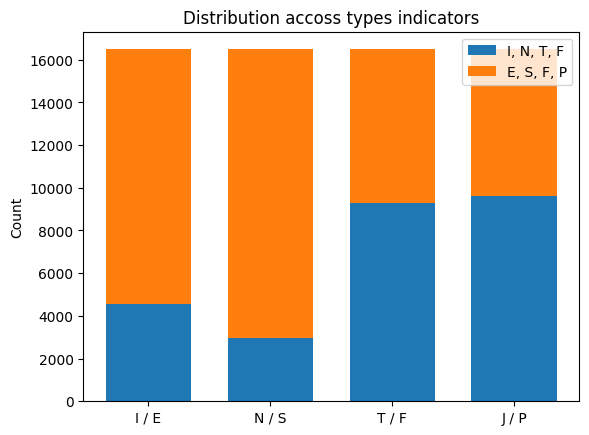

In [18]:
#Plotting the distribution of each personality type indicator
N = 4
bottom = (MBTI_DS_N['IE'].value_counts()[0], MBTI_DS_N['NS'].value_counts()[0], MBTI_DS_N['TF'].value_counts()[0], MBTI_DS_N['JP'].value_counts()[0])
top = (MBTI_DS_N['IE'].value_counts()[1], MBTI_DS_N['NS'].value_counts()[1], MBTI_DS_N['TF'].value_counts()[1], MBTI_DS_N['JP'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
# the width of the bars
width = 0.7

p1 = plt.bar(ind, bottom, width, label="I, N, T, F")
p2 = plt.bar(ind, top, width, bottom=bottom, label="E, S, F, P") 

plt.title('Distribution accoss types indicators')
plt.ylabel('Count')
plt.xticks(ind, ('I / E',  'N / S', 'T / F', 'J / P',))
plt.legend()

plt.show()


<Axes: title={'center': 'Features Correlation Heatmap'}>

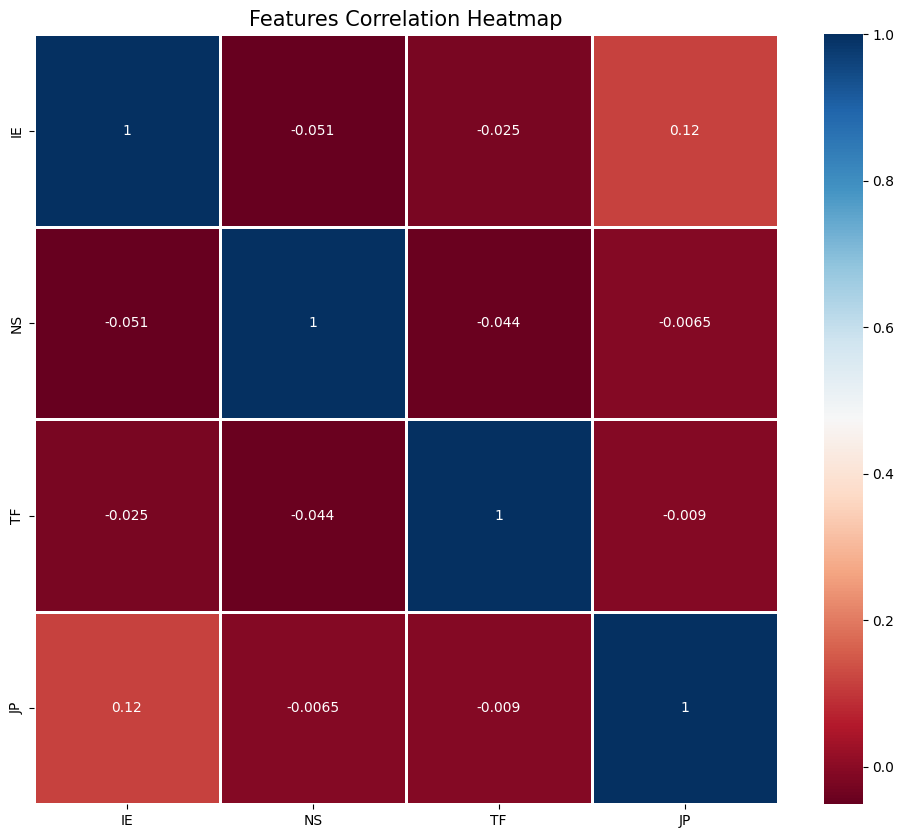

In [19]:
cmap = plt.cm.RdBu
corr = MBTI_DS_N[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(12,10))
plt.title('Features Correlation Heatmap', size=15)
sns.heatmap(corr, cmap=cmap,  annot=True, linewidths=1)


From this heatmap also, it is unclear if it shows anything valuable for interpretation



**SUMMARY**
We notice that there are a number of irrelevant words present in the dataset, such as "ha," "ar," and "Ti," which need to be removed. Additionally, we observe that among the most frequent words in the word clouds of individual personality types, are the names of the MBTI personality types themselves. Therefore, it is important to clean the posts by removing these MBTI words from each of them as part of the pre-processing stage before training the model to achieve better evaluation results.

**Pre-Processing Stage**

We preprocess the posts by using Lemmatization technique. Lemmatization groups together different inflected forms of a word so they can be analyzed as a single item. Unlike stemming, lemmatization takes into account the context of the word, making it a more suitable choice for our model. This technique links words with similar meanings to one word, resulting in a more accurate analysis.

In [20]:
    lemmatiser = WordNetLemmatizer()

# Remove the stop words for speed 
useless_words = stopwords.words("english")

# Remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP','ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]


Binarizing the each personality type feature



In [21]:
# Splitting the MBTI personality into 4 letters and binarizing it

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # Transform MBTI to binary vector
    return [b_Pers[l] for l in personality]

#Show result output for personality prediction
def translate_back(personality):
    # transform binary vector to MBTI personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in MBTI_DS_N.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)


Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [1 0 1 1]
 [0 0 0 0]
 [0 1 1 1]]


**Cleaning Data in posts**

In [22]:
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
MBTI_DS_N

[nltk_data] Error loading wordnet: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


,type,posts,word_each_comment,variance_word_count,length_posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.290000,4652,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.475600,7053,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.690000,5265,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.832400,6271,1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.457600,6111,0,1,1,1
...,...,...,...,...,...,...,...,...,...
7806,INTP,"@sobsjjun God,,pls take care 😕|||@sobsjjun Hir...",15.96,15.306467,6545,1,1,1,0
7807,INTP,@Ignis_02 wow last time i got intp https://t.c...,21.96,32.449600,10235,1,1,1,0
7808,ENTP,@akupilled A 100%|||@akupilled That SOMEONE wi...,22.86,28.547975,8416,0,1,1,0
7809,INFJ,If you’re #INTJ this one is for you | What is ...,33.36,50.830316,13800,1,1,0,1


In [23]:
def pre_process_text(MBTI_DS_N, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []
  len_MBTI_DS_N = len(MBTI_DS_N)
  i=0
  
  for row in MBTI_DS_N.iterrows():
      #Remove and clean comments
      posts = row[1].posts

      temp = posts.lower()
      
      temp = temp.strip()
      
      temp = contractions.fix(temp)
      #Remove url links 
      temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', temp)
      
      #Remove Non-words - keep only words
      temp = re.sub("[^a-zA-Z]", " ", temp)

      # Remove spaces > 1
      temp = re.sub(' +', ' ', temp).lower()

      #Remove multiple letter repeating words
      temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)
      
      #Remove stop words
      if remove_stop_words:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
      else:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
          
      #Remove MBTI personality words from posts
      if remove_mbti_profiles:
          for t in unique_type_list:
              temp = temp.replace(t,"")

      # transform mbti to binary vector
      # from sklearn.preprocessing import LabelEncoder
      # label_encoder = LabelEncoder()
      # print(row[1].type)
      # label_encoder.fit([row[1].type])
      # type_labelized = label_encoder.transform([row[1].type])[0]
      # print(type_labelized)
      # type_labelized = label_encoder.transform([row[1].type])[0]
      type_labelized = translate_personality(row[1].type) #or use lab_encoder.transform([row[1].type])[0]
      list_personality.append(type_labelized)
      # the cleaned data temp is passed here
      list_posts.append(temp)

  # returns the result
  print('list_posts',list_posts)
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)
  return list_posts, list_personality

list_posts, list_personality  = pre_process_text(MBTI_DS_N, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", MBTI_DS_N.posts[0])
print("\nPost after preprocessing:\n\n", list_posts[0])
print("\nMBTI before preprocessing:\n\n", MBTI_DS_N.type[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Example :

Post before preprocessing:

 0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
0    @Pericles216 @HierBeforeTheAC @Sachinettiyil T...
Name: posts, dtype: object

Post after preprocessing:

    moment sportscenter top ten play prank life changing experience life repeat today may perc experience immerse last thing  friend posted facebook committing suicide next day rest peace hello  sorry hear distress natural relationship perfection time every moment existence try figure hard time time growth welcome stuff game set match prozac wellbrutin least thirty minute moving leg mean moving sitting desk chair weed moderation maybe try edible healthier alternative basically come three item determined type whichever type want would likely use given type cognitive function whatnot left thing moderation sims indeed video game good one note good one somewhat subjective completely promoting death given sim dear  favorite video game growing current favorite video game cool appears late s

In [24]:
nRow, nCol = list_personality.shape
print(f'Number of posts = {nRow}  and No. of Personalities = {nCol} ')


Number of posts = 16486  and No. of Personalities = 4 


**Feature Engineering - TF-IDF**

In our model, we use Tf-idf feature engineering to determine the relevance and importance of a word in relation to a document within a collection of documents. This technique is particularly useful for training individual classifiers and scoring words in machine learning algorithms for natural language processing. We vectorize the dataset using both count vectorizer and tf-idf vectorizer, while only keeping words that appear between 10-70% of the posts.

In [25]:
# Vectorizing the database posts to a matrix of token counts for the model
cntizer = CountVectorizer(analyzer="word", 
                             max_features=1000,  
                             max_df=0.7,
                             min_df=0.1) 
# the feature should be made of word n-gram 

# Learn the vocabulary dictionary and return term-document matrix
print("Using CountVectorizer :")
X_cnt = cntizer.fit_transform(list_posts)

#The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names_out()))
print("10 feature names can be seen below")
print(feature_names[0:10])

# For the Standardization or Feature Scaling Stage :-
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print(X_tfidf.shape)


Using CountVectorizer :
10 feature names can be seen below
[(0, 'able'), (1, 'absolutely'), (2, 'act'), (3, 'actually'), (4, 'age'), (5, 'ago'), (6, 'agree'), (7, 'almost'), (8, 'alone'), (9, 'along')]

Using Tf-idf :
Now the dataset size is as below
(16486, 368)


**Therefore we now have 595 features for each user post.**


Splitting into X and Y variable

linkcode
Hence we split the features as :

X: User Posts in TF-IDF representation

Y: Personality type in Binarized MBTI form

In [26]:

personality_type = [ "IE: Introversion (I) | Extroversion (E)", "NS: Intuition    (N) | Sensing      (S)", 
                   "FT: Feeling      (F) | Thinking     (T)", "JP: Judging      (J) | Perceiving   (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])


IE: Introversion (I) | Extroversion (E)
NS: Intuition    (N) | Sensing      (S)
FT: Feeling      (F) | Thinking     (T)
JP: Judging      (J) | Perceiving   (P)


Let's see how the posts look in TF-IDF representation: (we have taken 1st post for demonstration)

In [27]:
print("X: First post in tf-idf representation\n%s" % X_tfidf[0])


X: First post in tf-idf representation
[0.         0.         0.         0.         0.08611389 0.07557231
 0.         0.         0.         0.         0.         0.
 0.         0.05169217 0.         0.         0.         0.
 0.         0.06136536 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.05966717 0.0739353  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.17533837 0.         0.05571573
 0.         0.08125326 0.08243646 0.07822792 0.10238244 0.
 0.         0.         0.         0.         0.0522561  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.0773758
 0.         0.         0.         0.04969985 0.         0.06257318
 0.1263154  0.         0.         0.         0.14205493 0.
 0.         0.         0.         0.         0.16188927 0.
 0.         0.         0.         0.         

Let's see how the posts look in Binarized MBTI personality indicator representation: (we have taken 1st post for demonstration)


In [28]:
print("For MBTI personality type : %s" % translate_back(list_personality[0,:]))
print("Y : Binarized MBTI 1st row: %s" % list_personality[0,:])


For MBTI personality type : INFJ
Y : Binarized MBTI 1st row: [0 0 0 0]


**Therefore we have successfully converted the textual data into numerical form**



**Training & Evaluating Models**

In [29]:
X = X_tfidf
Y = list_personality[:,l]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)


In [30]:
# Logistic Regression for MBTI dataset
# Individually training each mbti personlity type
for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = LogisticRegression() 
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))
    print("%s Classification report for Train Data" % (personality_type[l]))
    print(classification_report(y_train,model.predict(X_train)))
    print("%s Classification report for Test Data" % (personality_type[l]))
    print(classification_report(y_test, y_pred))
    print("\n")

IE: Introversion (I) | Extroversion (E) Accuracy: 72.16%
IE: Introversion (I) | Extroversion (E) Classification report for Train Data
              precision    recall  f1-score   support

           0       0.73      0.98      0.84      7950
           1       0.54      0.05      0.10      3095

    accuracy                           0.72     11045
   macro avg       0.63      0.52      0.47     11045
weighted avg       0.68      0.72      0.63     11045

IE: Introversion (I) | Extroversion (E) Classification report for Test Data
              precision    recall  f1-score   support

           0       0.73      0.97      0.84      3974
           1       0.36      0.04      0.07      1467

    accuracy                           0.72      5441
   macro avg       0.55      0.51      0.45      5441
weighted avg       0.63      0.72      0.63      5441



NS: Intuition    (N) | Sensing      (S) Accuracy: 81.22%
NS: Intuition    (N) | Sensing      (S) Classification report for Train Data


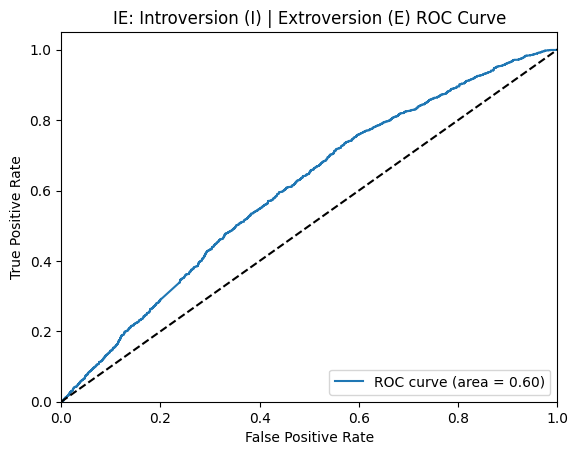

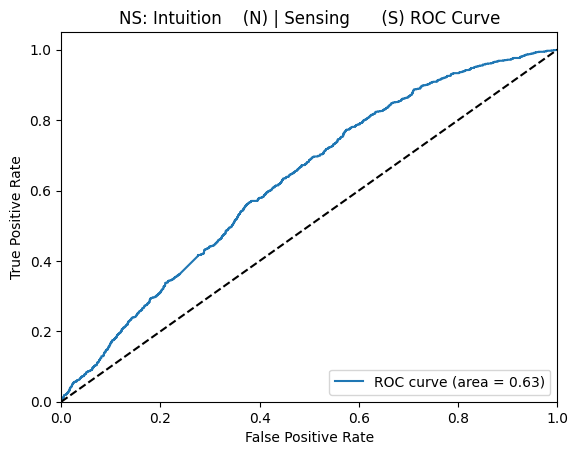

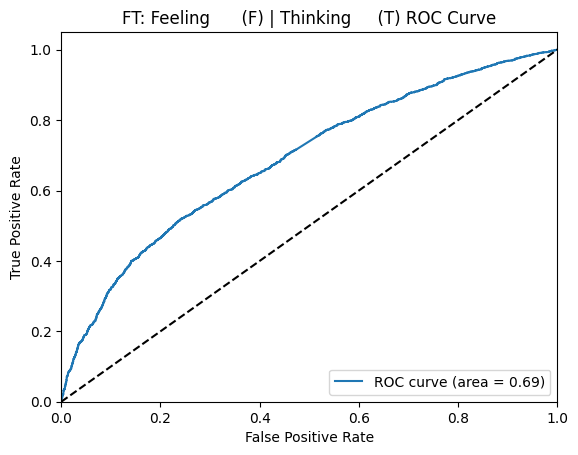

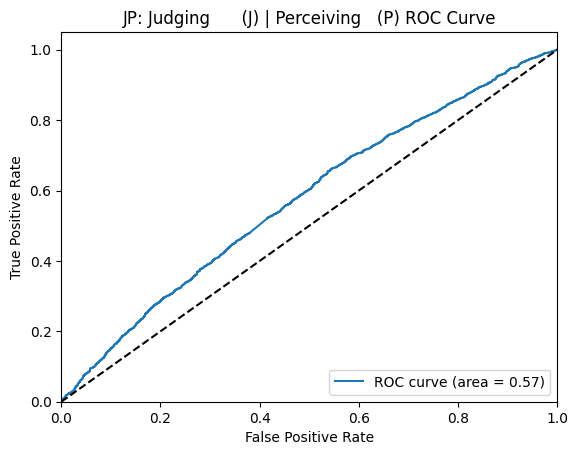

In [31]:
from sklearn.metrics import roc_curve, auc

for l in range(len(personality_type)):

    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = LogisticRegression() 
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict_proba(X_test)[:,1] # use predict_proba instead of predict for ROC curve
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('%s ROC Curve' % (personality_type[l]))
    plt.legend(loc="lower right")
    plt.show()



K-value 1

K-Nearest Neighbors - Train ConfusionMatrix

 Predicted     0     1
Actuall              
0          4604    30
1           297  6114

K-Nearest Neighbors - Train accuracy: 0.97

K-Nearest Neighbors - Train Classification Report
               precision    recall  f1-score   support

           0       0.94      0.99      0.97      4634
           1       1.00      0.95      0.97      6411

    accuracy                           0.97     11045
   macro avg       0.97      0.97      0.97     11045
weighted avg       0.97      0.97      0.97     11045



K-Nearest Neighbors - Test Confusion Matrix

 Predicted     0     1
Actuall              
0          1436   808
1          1973  1224

K-Nearest Neighbors - Test accuracy: 0.489

K-Nearest Neighbors - Test Classification Report
               precision    recall  f1-score   support

           0       0.42      0.64      0.51      2244
           1       0.60      0.38      0.47      3197

    accuracy                        

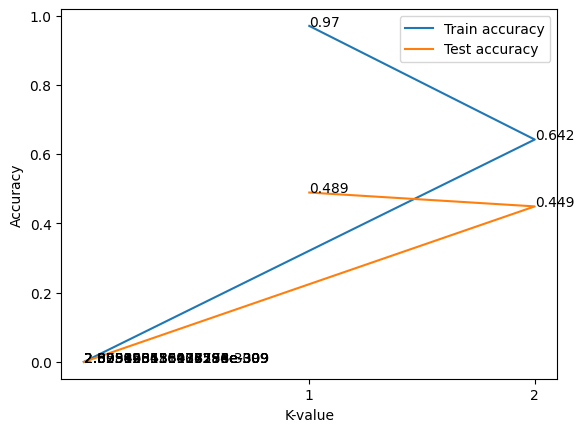

In [32]:
#KNN Classifier
from sklearn.metrics import accuracy_score,classification_report

# Tuning of K- value for Train & Test data
dummyarray = np.empty((5,3))
k_valchart = pd.DataFrame(dummyarray)
k_valchart.columns = ["K_value","Train_acc","Test_acc"]
k_vals = [1,2]
for i in range(len(k_vals)):
    knn_fit = KNeighborsClassifier(n_neighbors=k_vals[i],p=2,metric='minkowski')
    knn_fit.fit(X_train,y_train)
    print ("\nK-value",k_vals[i])
    tr_accscore = round(accuracy_score(y_train,knn_fit.predict(X_train)),3)
    print ("\nK-Nearest Neighbors - Train ConfusionMatrix\n\n",pd.crosstab( y_train, knn_fit.predict(X_train),rownames =["Actuall"],colnames = ["Predicted"]) )
    print ("\nK-Nearest Neighbors - Train accuracy:",tr_accscore)
    print ("\nK-Nearest Neighbors - Train Classification Report\n",classification_report(y_train,knn_fit.predict(X_train)))
    ts_accscore = round(accuracy_score(y_test,knn_fit.predict(X_test)),3)
    print ("\n\nK-Nearest Neighbors - Test Confusion Matrix\n\n",pd.crosstab( y_test,knn_fit.predict(X_test),rownames =["Actuall"],colnames = ["Predicted"]))
    print ("\nK-Nearest Neighbors - Test accuracy:",ts_accscore)
    print ("\nK-Nearest Neighbors - Test Classification Report\n",classification_report(y_test,knn_fit.predict(X_test)))
    k_valchart.loc[i, 'K_value'] = k_vals[i]
    k_valchart.loc[i, 'Train_acc'] = tr_accscore
    k_valchart.loc[i, 'Test_acc'] = ts_accscore

import matplotlib.pyplot as plt

# plot the train and test accuracy scores for different K-values
plt.plot(k_valchart['K_value'], k_valchart['Train_acc'], label='Train accuracy')
plt.plot(k_valchart['K_value'], k_valchart['Test_acc'], label='Test accuracy')
plt.xlabel('K-value')
plt.ylabel('Accuracy')
plt.xticks(k_valchart['K_value'])
plt.xticks([1,2])
for a,b in zip(k_valchart["K_value"],k_valchart["Train_acc"]):
    plt.text(a, b, str(b),fontsize=10)
for a,b in zip(k_valchart["K_value"],k_valchart["Test_acc"]):
    plt.text(a, b, str(b),fontsize=10)
plt.legend()
plt.show()


In [33]:
#XGBoost model for MBTI dataset 
# Individually training each mbti personlity type
for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

    # fit model on training data
    model = XGBClassifier()
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))
    print("%s Classification report for Train Data" % (personality_type[l]))
    print(classification_report(y_train,model.predict(X_train)))
    print("%s Classification report for Test Data" % (personality_type[l]))
    print(classification_report(y_test, y_pred))
    print("\n")


IE: Introversion (I) | Extroversion (E) Accuracy: 71.15%
IE: Introversion (I) | Extroversion (E) Classification report for Train Data
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      7950
           1       0.99      0.73      0.84      3095

    accuracy                           0.92     11045
   macro avg       0.95      0.87      0.90     11045
weighted avg       0.93      0.92      0.92     11045

IE: Introversion (I) | Extroversion (E) Classification report for Test Data
              precision    recall  f1-score   support

           0       0.74      0.93      0.83      3974
           1       0.38      0.11      0.18      1467

    accuracy                           0.71      5441
   macro avg       0.56      0.52      0.50      5441
weighted avg       0.64      0.71      0.65      5441



NS: Intuition    (N) | Sensing      (S) Accuracy: 80.79%
NS: Intuition    (N) | Sensing      (S) Classification report for Train Data


** THE END **